In [119]:
import torch
import csv

import numpy as np
import pandas as pd
from scipy import ndimage, stats

from PIL import Image
from matplotlib.colors import LinearSegmentedColormap
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

import torchvision
from torchvision import models
import torch.nn.functional as F

from captum.attr import GradientShap
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.metrics import infidelity, sensitivity_max, infidelity_perturb_func_decorator

from helpers import get_labels, get_input_image, get_rotated_input_image, get_input_image_with_filter, predict

default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

## Initialize Resnet18

[Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

In [74]:
model = models.resnet18(pretrained=True)
model = model.eval()

## Extract ImageNet class labels and get correct predicted label id for default image

In [75]:
labels_path, idx_to_labels = get_labels()
input, transformed_img = get_input_image()

In [76]:

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

In [77]:
output.cpu().detach().numpy()[0][99]

0.45693368

In [78]:
pred_label_idx

tensor([[99]])

In [79]:
prediction_score

tensor([[0.4569]], grad_fn=<TopkBackward>)

In [80]:
predicted_label, pred_label_idx, prediction_score = predict(model, input, idx_to_labels)
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: goose ( 0.4569336771965027 )


In [81]:
transformed_img.shape

torch.Size([3, 224, 224])

In [82]:
baseline = torch.randn(input.shape)

In [83]:
input.shape

torch.Size([1, 3, 224, 224])

## Get Guided Backprop attribution

[Axiomatic Attribution for Deep Networks, Mukund Sundararajan et al. 2017](https://arxiv.org/abs/1703.01365)

In [84]:
sali = GradientShap(model)
attributions_sali = sali.attribute(input, baseline, target=pred_label_idx)

In [85]:
attributions_sali.squeeze().cpu().detach().numpy().shape

(3, 224, 224)

In [86]:
baseline = torch.randn(list(input.shape))

In [87]:
baseline.device

device(type='cpu')

In [88]:
torch.randn(list(input.shape)).shape

torch.Size([1, 3, 224, 224])

## Generate explanation with NoiseTunnel

[Sanity Checks for Saliency Maps, Julius Adebayo et al. 2018](https://arxiv.org/abs/1810.03292)

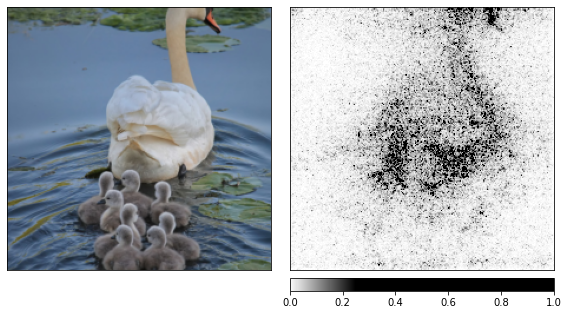

In [91]:
noise_tunnel = NoiseTunnel(sali)

attributions_sali_nt = noise_tunnel.attribute(input, nt_samples=10, nt_type='smoothgrad_sq', target=1,  baselines=baseline)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_sali_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [15]:

input_rotate, transformed_img_rotate = get_rotated_input_image()

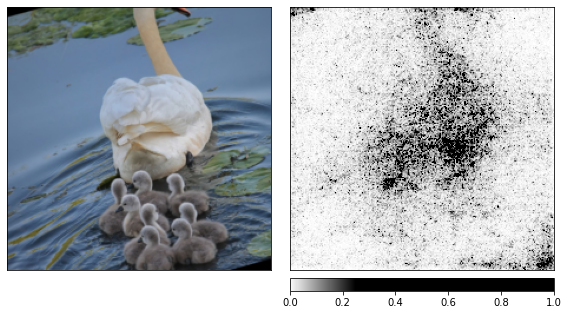

In [16]:
predicted_label_rotate, pred_label_idx_rotate, prediction_score_rotate = predict(model, input_rotate, idx_to_labels)
attributions_rotate = noise_tunnel.attribute(input_rotate, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx_rotate,  baselines=baseline)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_rotate.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img_rotate.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [17]:

input_filter, transformed_img_filter = get_input_image_with_filter()

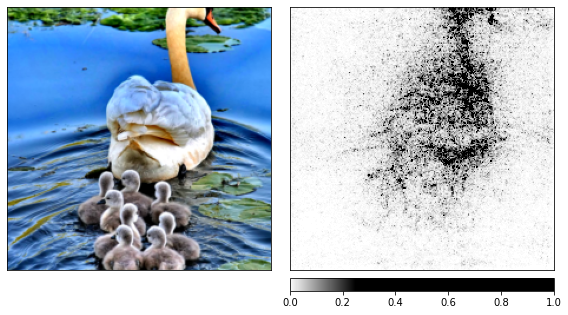

In [18]:
predicted_label_filter, pred_label_idx_filter, prediction_score_filter = predict(model, input_filter, idx_to_labels)
attributions_filter = noise_tunnel.attribute(input_filter, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx_filter,  baselines=baseline)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_filter.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img_filter.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [40]:
attr_15 = ndimage.rotate(attributions_sali_nt.squeeze().cpu().detach().numpy(), -15, reshape=False, axes=(1,2))
attr_15.shape

(3, 224, 224)

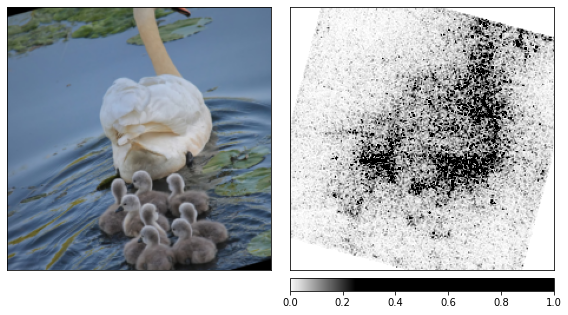

In [41]:
_ = viz.visualize_image_attr_multiple(np.transpose(attr_15, (1,2,0)),
                                      np.transpose(transformed_img_rotate.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [28]:
input.shape

torch.Size([1, 3, 224, 224])

In [29]:
attributions_sali_nt.shape

torch.Size([1, 3, 224, 224])

In [30]:
img = np.moveaxis(input.squeeze().cpu().detach().numpy(), 0, -1)
img_rotate = np.moveaxis(input_rotate.squeeze().cpu().detach().numpy(), 0, -1)
img_filter = np.moveaxis(input_filter.squeeze().cpu().detach().numpy(), 0, -1)

In [31]:
attr = np.moveaxis(attributions_sali_nt.squeeze().cpu().detach().numpy(), 0, -1)
att_rotate = np.moveaxis(attributions_rotate.squeeze().cpu().detach().numpy(), 0, -1)
att_filter = np.moveaxis(attributions_filter.squeeze().cpu().detach().numpy(), 0, -1)

In [32]:
img.shape

(224, 224, 3)

In [35]:
rotated_attr = np.moveaxis(attr_15, 0, -1)

In [33]:
attributions_sali_nt.squeeze().cpu().detach().numpy().shape

(3, 224, 224)

In [125]:
ssim_noise = ssim(attr, att_rotate,
                  win_size=11,
                  data_range=0.01, multichannel=True)

In [126]:
ssim_noise

0.9193404545449896

In [73]:
x = attributions_sali_nt.squeeze().cpu().detach().numpy() * 255
x = np.uint8(x)

In [118]:
attr.max()

0.0031523171

In [120]:
correlation, _ = stats.spearmanr(attr.flatten(), att_rotate.flatten())
correlation

0.4970939567846703

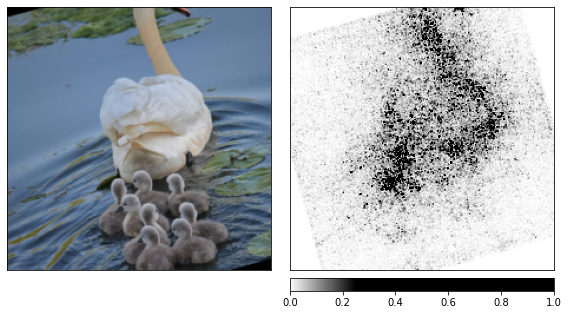

## Calculate Infidelity and Sensitivity metrics

[On the (In)fidelity and Sensitivity for Explanations](https://arxiv.org/abs/1901.09392)

In [26]:
# We need that for metric calculation
input.requires_grad = True

In [27]:
def perturb_fn(inputs):
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float()
    return noise, inputs - noise

infid = infidelity(model, perturb_fn, input, attributions_sali, target=pred_label_idx)

In [29]:
sens = sensitivity_max(sali.attribute, input, target=pred_label_idx, baselines=baseline)

In [30]:
print(f"Infidelity: {infid.numpy()[0]}, Sensitivity: {sens.numpy()[0]}")

Infidelity: 0.0006409400957636535, Sensitivity: 1.4804266691207886


### Append results to results file

In [11]:
fields=['GradientShap',infid.numpy()[0],sens.numpy()[0]]
with open('../data/results.csv','a') as fd:
    writer = csv.writer(fd)
    writer.writerow(fields)

In [65]:
data = np.array([
    ['plant1', 'label1', 1],
    ['plant2', 'label1', 1],
    ['plant3', 'label2', 2],
    ['plant4', 'label4', 4],
    ['plant5', 'label2', 2]
])

In [66]:

data_df = pd.DataFrame(data)

In [71]:
new_df = pd.DataFrame()
for rotation in [0, -30, -15, 15, 30]:
    df1 = data_df.copy()
    df1["rotation"] = str(rotation)
    new_df = pd.concat([new_df, df1], ignore_index=True)
    new_df = new_df.sort_values(by=[0], ignore_index=True)

In [72]:
new_df

,0,1,2,rotation
0,plant1,label1,1,0
1,plant1,label1,1,-30
2,plant1,label1,1,-15
3,plant1,label1,1,15
4,plant1,label1,1,30
5,plant2,label1,1,0
6,plant2,label1,1,-30
7,plant2,label1,1,-15
8,plant2,label1,1,15
9,plant2,label1,1,30
